## Convolutional Dictionary Learning Tutorial 

The code used in this script is modified from https://github.com/tbardouille/camcan_CSC_beta

This method takes in preprocessed MEG data in .fif file format. For each pattern detected by the algorithm, 3 components are returned representing the spatial pattern, temporal pattern, and activation timing throughout the recording.

Note that this tutorial relies on utility scripts utils_csc.py and utils_plot.py available at https://github.com/lindseypower/BurstDetection_Tutorials

In [1]:
# Imports 
import seaborn as sns
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from codecs import ignore_errors
import scipy.signal as ss
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from joblib import Memory, Parallel, delayed
from scipy import stats
from scipy import signal
import mne
import scipy.io as io

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs, compute_proj_ecg, compute_proj_eog)

from alphacsc import BatchCDL, GreedyCDL
from alphacsc.utils.signal import split_signal
from alphacsc.utils.convolution import construct_X_multi

In [2]:
# Read raw data from BIDS file
bp = BIDSPath(
    root="ds000247",
    subject="0002",
    task="rest",
    run="01",
    datatype="meg",
    extension=".ds",
    session="01",
)
raw = read_raw_bids(bp)

ds directory : /export03/data/lindseyp/burst_methods_review/ds000247/sub-0002/ses-01/meg/sub-0002_ses-01_task-rest_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -1.67   73.89    0.00 mm <->   -1.67   73.89    0.00 mm (orig :  -49.81   55.70 -260.09 mm) diff =    0.000 mm
       1.67  -73.89    0.00 mm <->    1.67  -73.89   -0.00 mm (orig :   52.37  -51.09 -257.89 mm) diff =    0.000 mm
      98.00    0.00    0.00 mm <->   98.00    0.00    0.00 mm (orig :   73.54   68.43 -256.15 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 3 EEG channels from channel info
    3 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /export03/data/lindseyp/burst_methods_review/ds000247/sub-0002/ses-01/meg/sub-0002_ses-01_task-r

/tmp/ipykernel_903763/1936514790.py:11: RuntimeWarning: No BIDS -> MNE mapping found for channel type "SYSCLOCK". Type of channel "SCLK01-177" will be set to "misc".
  raw = read_raw_bids(bp)
/tmp/ipykernel_903763/1936514790.py:11: RuntimeWarning: participants.tsv file not found for ds000247/sub-0002/ses-01/meg/sub-0002_ses-01_task-rest_run-01_meg.ds
  raw = read_raw_bids(bp)


In [3]:
# Preprocess the raw data (bandpass and resample)
raw.load_data()
raw.filter(l_freq=1, h_freq=50)
Fs = 1000
raw = raw.resample(Fs, npad='auto',verbose=False)

Reading 0 ... 1439999  =      0.000 ...   600.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 7921 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    4.6s


Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 831 (average pulse 83.1 / min.)
Not setting metadata
831 matching events found
No baseline correction applied
Using data from preloaded Raw for 831 events and 1001 original time points ...
1 bad epochs dropped
Including 0 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    2.8s


Not setting metadata
832 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 832 events and 601 original time points ...
1 bad epochs dropped
No channels 'grad' found. Skipping.
Adding projection: axial--0.200-0.400-PCA-01 (exp var=83.2%)
Adding projection: axial--0.200-0.400-PCA-02 (exp var=11.5%)
No channels 'eeg' found. Skipping.
Done.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


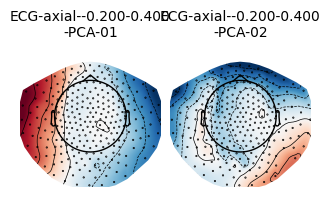

2 projection items deactivated
Using EOG channels: VEOG, HEOG
EOG channel index for this subject is: [298 299]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel VEOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 166 significant peaks
Number of EOG events detected: 166
Not setting metadata
166 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Using data from preloaded Raw for

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    2.8s


Not setting metadata
166 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data from preloaded Raw for 166 events and 401 original time points ...
0 bad epochs dropped
No channels 'grad' found. Skipping.
Adding projection: axial--0.200-0.200-PCA-01 (exp var=96.7%)
Adding projection: axial--0.200-0.200-PCA-02 (exp var=1.3%)
Adding projection: axial--0.200-0.200-PCA-03 (exp var=0.8%)
No channels 'eeg' found. Skipping.
Done.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


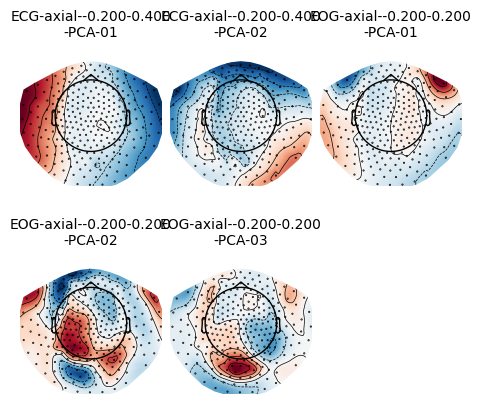

5 projection items deactivated
Created an SSP operator (subspace dimension = 5)
5 projection items activated
SSP projectors applied...


<RawCTF | sub-0002_ses-01_task-rest_run-01_meg.meg4, 300 x 600000 (600.0 s), ~1.34 GB, data loaded>

In [4]:
# Apply SSP projectors to remove ECG/EOG artifacts 
ecg_evoked = create_ecg_epochs(raw).average()
ecg_projs, ecg_events = compute_proj_ecg(raw,n_mag=2, reject=None)
mne.viz.plot_projs_topomap(ecg_projs, info=raw.info)
raw.add_proj(ecg_projs)

eog_evoked = create_eog_epochs(raw).average()
eog_projs, events = compute_proj_eog(raw, n_mag=3, reject=None)
mne.viz.plot_projs_topomap(eog_projs, info=raw.info)
raw.add_proj(eog_projs)

raw.apply_proj()

### 1. Set Model Parameters 

The CDL model requires the user to define a pattern duration ("atom_duration") and a number of patterns to detect ("n_atoms"). The pattern duration is particularly important for identifying bursts and should be set to a window length about 2x the approximate burst duration of interest. Adjusting the number of patterns allows you to view a larger variety of more or less frequently occuring patterns. 

More information about adjusting other parameters can be found at https://alphacsc.github.io/stable/index.html

In [5]:
# Set some global variables #
EXP_PARAMS = {
    "sfreq": 1000.,             
    "atom_duration": 0.5,   # pattern duration in seconds    
    "n_atoms": 6,         # number of patterns to detect     
    "reg": 0.2,                
    "eps": 1e-5,               
    "tol_z": 1e-3,             
}

CDL_PARAMS = {
    'n_atoms': EXP_PARAMS['n_atoms'],
    'n_times_atom': int(np.round(EXP_PARAMS["atom_duration"] * EXP_PARAMS['sfreq'])),
    'rank1': True, 'uv_constraint': 'separate',
    'window': True,
    'unbiased_z_hat': True,
    'D_init': 'chunk',
    'lmbd_max': 'scaled',
    'reg': EXP_PARAMS['reg'],
    'n_iter': 100,
    'eps': EXP_PARAMS['eps'],
    'solver_z': 'lgcd',
    'solver_z_kwargs': {'tol': EXP_PARAMS['tol_z'],
                        'max_iter': 1000},
    'solver_d': 'alternate_adaptive',
    'solver_d_kwargs': {'max_iter': 300},
    'sort_atoms': True,
    'verbose': 1,
    'random_state': 0,
    'use_batch_cdl': True,
    'n_splits': 20,
    'n_jobs': 5
}

### 2. Apply CDL 

CDL relies on utility scripts and integrated python packages (alphacsc; Jas et al., 2017; Dupre la Tour et al., 2018). Therefore, local processing of the data is not required and a simple function call will execute the necessary steps to fit the CDL model to the data. 

Calling 'run_csc' generates a cdl_model object containing a spatial pattern (u_hat), a temporal pattern (v_hat), and an activation vector (z_hat; length of overall recording). Burst shapes and spatial weights can be inferred fromt the v and u vectors, respectively. Burst timing and power can be inferred from the z vector. 

More information on the specific processing steps of the model can be found in utils_csc.py available at https://github.com/lindseypower/BurstDetection_Tutorials

In [6]:
# Function to run CDL on given dataset given globally-defined model parameters
def run_csc(X, **cdl_params):
    """Run a CSC model on a given signal X.

    Parameters
    ----------
    X : numpy.ndarray
        the data to run the CSC on

    cdl_params : dict
        dictionary of CSC parameters, such as 'n_atoms', 'n_times_atoms', etc.

    Returns
    -------
    cdl_model

    z_hat_

    """
    print('Computing CSC')

    cdl_params = dict(cdl_params)
    n_splits = cdl_params.pop('n_splits', 1)
    use_batch_cdl = cdl_params.pop('use_batch_cdl', False)
    if use_batch_cdl:
        cdl_model = BatchCDL(**cdl_params)
    else:
        cdl_model = GreedyCDL(**cdl_params)

    if n_splits > 1:
        X_splits = split_signal(X, n_splits=n_splits, apply_window=True)
        X = X[None, :]
    else:
        X_splits = X.copy()

    # Fit the model and learn rank1 atoms
    print('Running CSC')
    cdl_model.fit(X_splits)

    z_hat_ = cdl_model.transform(X)
    return cdl_model, z_hat_

In [7]:
# Run CDL model on MEG channels in dataset
data_len = 600

raw.pick_types(meg=True, ref_meg=False)
dat = raw.get_data(picks=['meg'])
dat = dat[0:int(Fs*data_len/2)]
cdl_model, z_hat_ = run_csc(dat,**CDL_PARAMS)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
Computing CSC
Running CSC
.................................................+

[BatchCDL] Converged after 50 iteration, (dz, du) = 7.987e-06, 3.528e-06
[BatchCDL] Fit in 779.0s
Refitting the activation to avoid amplitude bias...done


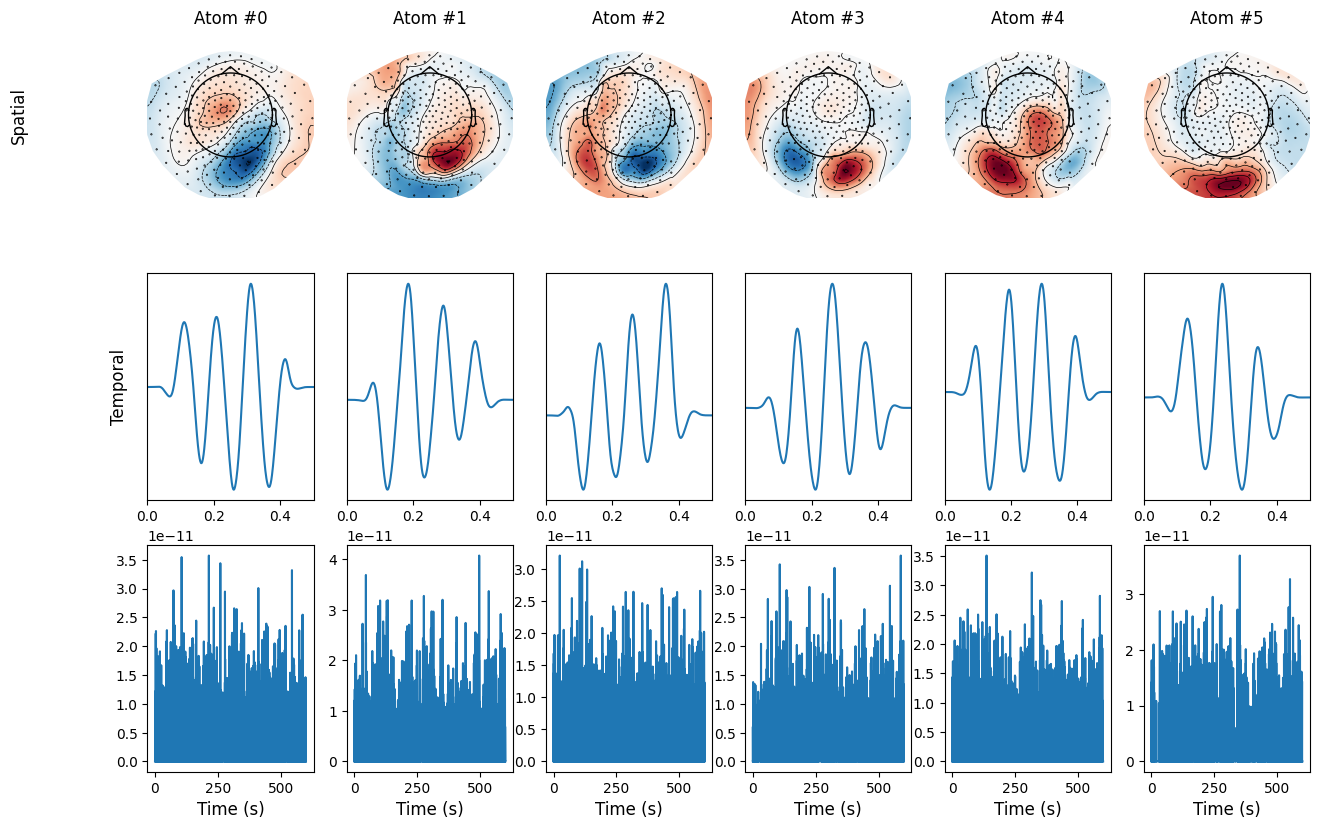

In [8]:
## Plotting ##

# Read in a layout file for plotting the sensor topography 

# Set plotting parameters 
Fs = 1000
fontsize = 12
n_atoms_per_fig = 6
n_plot_per_atom = 3
n_atoms_est = z_hat_.shape[1]
info = raw.info
atom_duration = cdl_model.v_hat_.shape[-1] / Fs
figsize = (15, 10)

atoms_in_figs = np.arange(0, n_atoms_est + 1, n_atoms_per_fig)
atoms_in_figs = list(zip(atoms_in_figs[:-1], atoms_in_figs[1:]))

# Loop through each pattern detected by CDL and create a plot with the u, v, and z vectors displayed for each 
burst_proxim_df = []
figs = []
for fig_idx, (atoms_start, atoms_stop) in enumerate(atoms_in_figs, start=1):
    fig, axes = plt.subplots(
        n_plot_per_atom, n_atoms_per_fig, figsize=figsize)
    figs.append(fig)
    fig.suptitle(None, fontsize=fontsize)
    for i_atom, kk in enumerate(range(atoms_start, atoms_stop)):
        ax = axes[0, i_atom]
        ax.set_title("Atom #" + str(kk), fontsize=fontsize)

        # Spatial pattern
        u_hat = cdl_model.u_hat_[kk]
        mne.viz.plot_topomap(u_hat, info,axes=ax, show=False)
        if i_atom == 0:
            ax.set_ylabel("Spatial", labelpad=86, fontsize=fontsize)

        # Temporal pattern
        ax = axes[1, i_atom]
        v_hat = cdl_model.v_hat_[kk]
        t = np.arange(v_hat.size) / Fs
        ax.plot(t, v_hat)
        #ax.grid(True)
        ax.set_xlim(0, atom_duration)  # crop x axis
        if i_atom == 0:
            ax.set_ylabel("Temporal", labelpad=14, fontsize=fontsize)
        ax.set_yticks([])

        # Atom's activations
        padding = np.zeros(int(atom_duration*Fs-1))
        z_hat = z_hat_[0,kk,:]
        z_hat = np.concatenate([z_hat, padding])
        ax = axes[2, i_atom]
        t1 = np.arange(0,dat.shape[1])/ Fs
        ax.plot(t1, z_hat)
        ax.set_xlabel("Time (s)", fontsize=fontsize)
plt.show()

Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


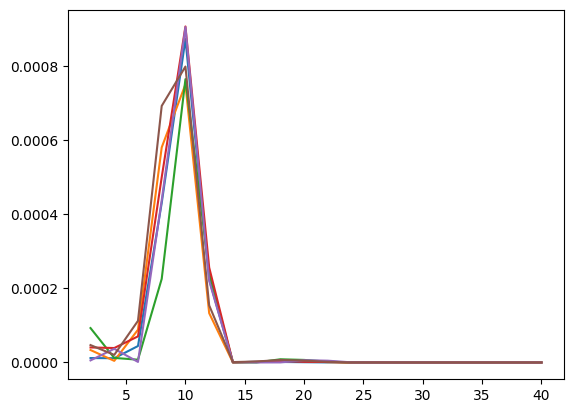

In [9]:
# Plot PSD to show the frequency composition of each detected pattern
v_hat = cdl_model.v_hat_
v_hat.shape

PSD0, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[0,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD1, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[1,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD2, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[2,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD3, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[3,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD4, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[4,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD5, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[5,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)

plt.plot(PSD_fVec, PSD0)
plt.plot(PSD_fVec, PSD1)
plt.plot(PSD_fVec, PSD2)
plt.plot(PSD_fVec, PSD3)
plt.plot(PSD_fVec, PSD4)
plt.plot(PSD_fVec, PSD5)
plt.show()

Most of these atoms resemble occipital alpha type patterns because alpha tends to be the dominant frequency in the signal. If we are interested in a different frequency (e.g., beta bursts) we may wish to apply a tighter bandpass to the signal to target the frequency range of interest.

In [10]:
# Filter the data to 15-30 Hz frequency range and then run CDL model again
raw.filter(15,30)
dat = raw.get_data(picks=['meg'])
dat = dat[0:int(Fs*data_len/2)]
cdl_model, z_hat_ = run_csc(dat,**CDL_PARAMS)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 881 samples (0.881 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.0s


Computing CSC
Running CSC
.................................................+
....
[BatchCDL] Converged after 54 iteration, (dz, du) = 9.919e-06, 6.259e-06
[BatchCDL] Fit in 870.0s
Refitting the activation to avoid amplitude bias...done


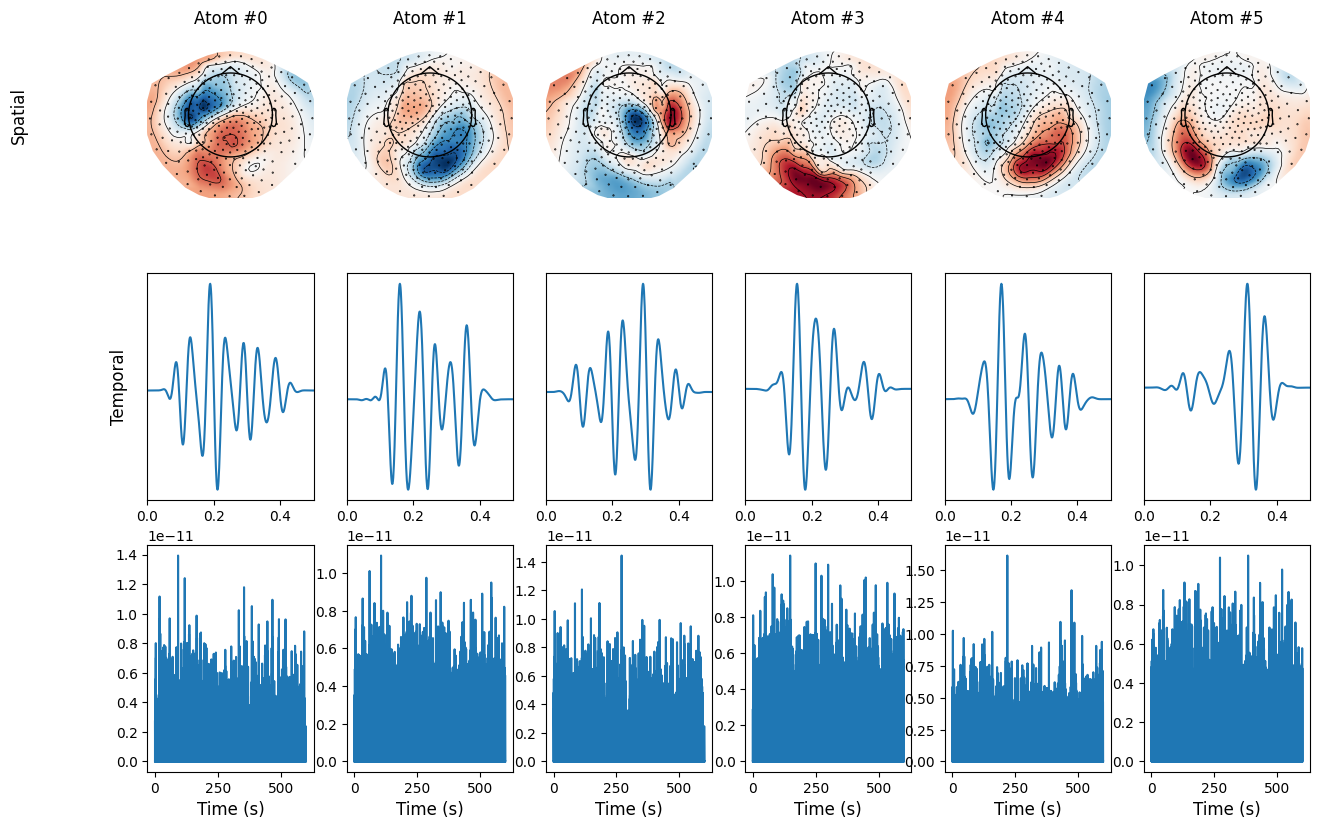

In [11]:
### Plotting ###

atoms_in_figs = np.arange(0, n_atoms_est + 1, n_atoms_per_fig)
atoms_in_figs = list(zip(atoms_in_figs[:-1], atoms_in_figs[1:]))

# Loop through each pattern detected by CDL and create a plot with the u, v, and z vectors displayed for each 
burst_proxim_df = []
figs = []
for fig_idx, (atoms_start, atoms_stop) in enumerate(atoms_in_figs, start=1):
    fig, axes = plt.subplots(
        n_plot_per_atom, n_atoms_per_fig, figsize=figsize)
    figs.append(fig)
    fig.suptitle(None, fontsize=fontsize)
    for i_atom, kk in enumerate(range(atoms_start, atoms_stop)):
        ax = axes[0, i_atom]
        ax.set_title("Atom #" + str(kk), fontsize=fontsize)

        # Spatial pattern
        u_hat = cdl_model.u_hat_[kk]
        mne.viz.plot_topomap(u_hat,  info,axes=ax, show=False)
        if i_atom == 0:
            ax.set_ylabel("Spatial", labelpad=86, fontsize=fontsize)

        # Temporal pattern
        ax = axes[1, i_atom]
        v_hat = cdl_model.v_hat_[kk]
        t = np.arange(v_hat.size) / Fs
        ax.plot(t, v_hat)
        #ax.grid(True)
        ax.set_xlim(0, atom_duration)  # crop x axis
        if i_atom == 0:
            ax.set_ylabel("Temporal", labelpad=14, fontsize=fontsize)
        ax.set_yticks([])

        # Atom's activations
        padding = np.zeros(int(atom_duration*Fs-1))
        z_hat = z_hat_[0,kk,:]
        z_hat = np.concatenate([z_hat, padding])
        ax = axes[2, i_atom]
        t1 = np.arange(0,dat.shape[1])/ Fs
        ax.plot(t1, z_hat)
        ax.set_xlabel("Time (s)", fontsize=fontsize)
plt.show()

Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


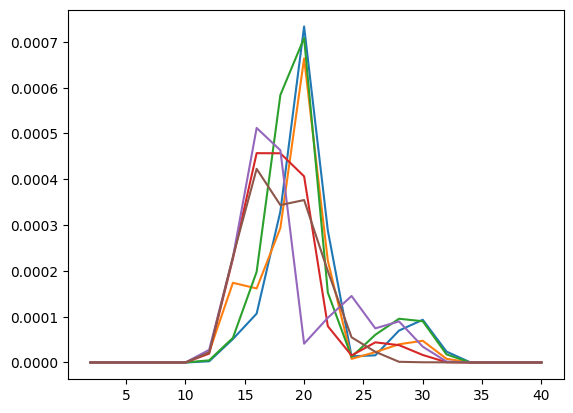

In [12]:
# Plot PSD to show the frequency composition of each detected pattern
v_hat = cdl_model.v_hat_
v_hat.shape

PSD0, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[0,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD1, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[1,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD2, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[2,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD3, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[3,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD4, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[4,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD5, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[5,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)

plt.plot(PSD_fVec, PSD0)
plt.plot(PSD_fVec, PSD1)
plt.plot(PSD_fVec, PSD2)
plt.plot(PSD_fVec, PSD3)
plt.plot(PSD_fVec, PSD4)
plt.plot(PSD_fVec, PSD5)
plt.show()

Now we can see that the patterns have waveforms resembling beta bursts. You can adjust the model parameters (e.g., number of patterns, length of pattern) to explore different types of model outputs. 